# IMPORT LIBRARIES

In [1]:
import pandas as pd
import numpy as np
import sys
import os
import random
from pathlib import Path

# Image processing
import imageio
import cv2
import skimage.transform


# Charts
import matplotlib.pyplot as plt
import seaborn as sns

# ML, statistics
import scipy
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score, ConfusionMatrixDisplay

# Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout, Activation, BatchNormalization, MaxPooling2D, GlobalAveragePooling2D, AveragePooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras import backend as K

# SETTINGS

## Global

In [2]:
# Settings
plt.style.use('fivethirtyeight')
#plt.style.use('seaborn')

# toy=True - development mode, small samples, limited training, fast run
# toy=False - full data, slow learning and run
toy=False

#set size of validation set and test set in percentage
validation_size = 10
test_size = 10

# Generators Paramenters
batch_size = 32
img_size = (224,224)

## Dataset Parameters

In [3]:
# Dataset Root Path
dataset_path = "../input/rx-covid-and-gan/COVID-19_Radiography_Dataset+GAN"

# Folder Paths
covid_path = dataset_path + "/COVID/images"
lungOpacity_path = dataset_path + "/Lung_Opacity/images"
normal_path = dataset_path + "/Normal/images"
viralPneumonia_path = dataset_path + "/Viral Pneumonia/images"

# LABELS LOCAL Array
#labels = ['COVID', 'Lung Opacity', 'Normal', 'Viral Pneumonia']
labels = ['COVID', 'Normal', 'Viral Pneumonia']

# DATA PREPARATION

In [4]:
# Generate Filename list
def filename_list():

    if toy :
        random.seed(100)
        filenames = random.sample(os.listdir(covid_path), 200) + random.sample(os.listdir(lungOpacity_path), 200) + random.sample(os.listdir(normal_path), 200) + random.sample(os.listdir(viralPneumonia_path), 200)
    else :
       #filenames = os.listdir(covid_path) + os.listdir(lungOpacity_path) + os.listdir(normal_path) + os.listdir(viralPneumonia_path)
        filenames = os.listdir(covid_path) + os.listdir(normal_path) + os.listdir(viralPneumonia_path)

    return filenames

In [5]:
def dataframe_generation(files):
    
    categories = []
    for filename in files:
        category = filename.split('-')[0]
        if category == labels[0]:
            categories.append(str(0))
        elif category == labels[1]:
            categories.append(str(1))
        elif category == labels[2]:
            categories.append(str(2))
        #elif category == labels[3]:
         #   categories.append(str(3))

    for i in range(len(files)):
        if labels[0] in files[i]:
            files[i] = os.path.join(covid_path, files[i])
        #elif labels[1] in files[i]:
            #files[i] = os.path.join(lungOpacity_path, files[i])
        elif labels[1] in files[i]:
            files[i] = os.path.join(normal_path, files[i])
        elif labels[2] in files[i]:
            files[i] = os.path.join(viralPneumonia_path, files[i])
    
    df = pd.DataFrame({
        'filename': files,
        'category': categories
    })

    return df

## Generate Dataset

In [6]:
filenames = filename_list()
dataset_df = dataframe_generation(filenames)

dataset_df.head()

,filename,category
0,../input/rx-covid-and-gan/COVID-19_Radiography...,0
1,../input/rx-covid-and-gan/COVID-19_Radiography...,0
2,../input/rx-covid-and-gan/COVID-19_Radiography...,0
3,../input/rx-covid-and-gan/COVID-19_Radiography...,0
4,../input/rx-covid-and-gan/COVID-19_Radiography...,0


In [7]:
def read_img(id):
    """
    Read image by it's id
    """
    file=id
    im=cv2.imread(file)
    return im

def draw_sample_images(dataframe, ncols, labels):

        ncols=ncols
        n_rows = len(labels)

        f, ax = plt.subplots(nrows=n_rows,ncols=ncols, 
                             figsize=(4*ncols,5*2))
        i=-1
        captions=labels
        
        for label in range(n_rows):
            i=i+1
            samples = dataframe[dataframe["category"].astype(int) == label].filename.sample(ncols).values
            for j in range(0,ncols):
                file_id=samples[j]
                im=read_img(file_id)
                ax[i, j].imshow(im)
                ax[i, j].set_title(captions[i], fontsize=16)  
        plt.tight_layout()
        plt.show()

In [8]:
def plot_data_distribution(dataframe):
    y = np.bincount(dataframe.category)
    x = labels
    fig, ax = plt.subplots(figsize=(10,8))
    plt.bar(x, y,width=0.7)
    ax.set_xticks(x)
    ax.set_aspect('auto')
    plt.show()

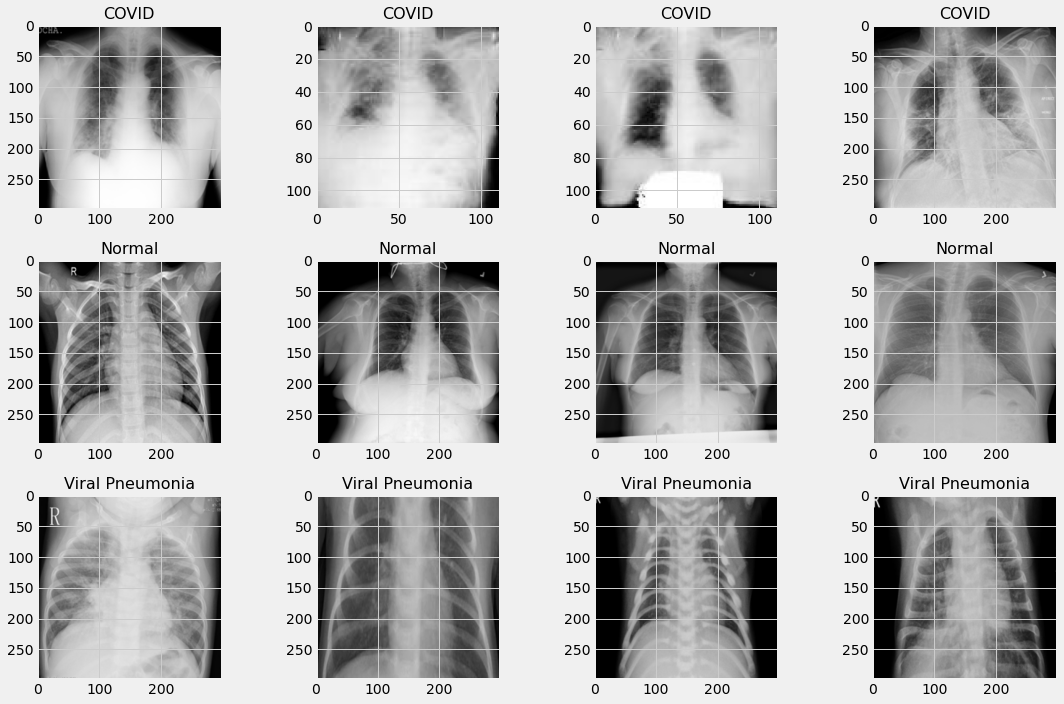

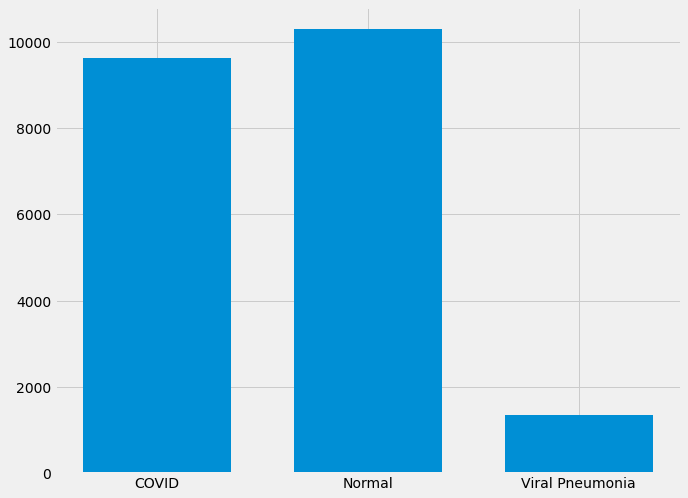

In [9]:
draw_sample_images(dataset_df, 4, labels)
plot_data_distribution(dataset_df)

## Split in Train, Validation and Test

In [10]:
def sets_split(dataframe):
    x_1_split = (validation_size + test_size)/100
    x_2_split = round(test_size / (validation_size + test_size), 2)

    train_df, valTest_df = train_test_split(dataframe, test_size=x_1_split, random_state=24)
    val_df, test_df = train_test_split(valTest_df, test_size=x_2_split, random_state=24)

    return train_df, val_df, test_df

In [11]:
train, validation, test = sets_split(dataset_df)

## Generators

In [12]:
_datagen = ImageDataGenerator(
            #rotation_range=15,
            rescale=1./255,
            #shear_range=0.1,
            #zoom_range=0.2,
            #horizontal_flip=True,
            #width_shift_range=0.1,
            #height_shift_range=0.1   
            )

_test_datagen=ImageDataGenerator(rescale=1./255)

In [13]:
train_generator = _datagen.flow_from_dataframe(
            dataframe=train,
            x_col="filename",
            y_col="category",
            batch_size=batch_size,
            seed=42,
            shuffle=True,
            class_mode="categorical",
            color_mode="rgb",
            target_size=img_size)
print('Train generator created')

Found 17002 validated image filenames belonging to 3 classes.
Train generator created


In [14]:
val_generator = _test_datagen.flow_from_dataframe(
            dataframe=validation,
            x_col="filename",
            y_col="category",
            batch_size=batch_size,
            seed=42,
            shuffle=False,
            class_mode="categorical",
            color_mode="rgb",
            target_size=img_size)    
print('Validation generator created')

Found 2125 validated image filenames belonging to 3 classes.
Validation generator created


In [15]:
test_generator = _test_datagen.flow_from_dataframe(
            dataframe=test,
            x_col="filename",
            y_col=None,
            class_mode=None,
            batch_size=batch_size,
            seed=42,
            shuffle=False,
            color_mode="rgb",
            target_size=img_size)     
print('Test generator created')

Found 2126 validated image filenames.
Test generator created


# MODEL GENERATION

## Metrics Aux Functions

In [16]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

## Model Creation

In [17]:
def create_model(size):
        baseModel = VGG16(input_shape=(size,size,3), weights='imagenet', include_top=False)

        for layer in baseModel.layers:
            layer.trainable = False

        headModel = baseModel.output
        headModel = AveragePooling2D()(headModel)
        headModel = Flatten()(headModel)
        headModel = Dense(128, activation="relu")(headModel)
        headModel = Dropout(0.2)(headModel)
        headModel = Dense(3, activation='softmax')(headModel)

        model=Model(inputs=baseModel.input,outputs=headModel) 
            
        model.compile(optimizer= Adam(0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy', f1_m, precision_m, recall_m])
        
        return model

In [18]:
model = create_model(224)
model.summary()

2022-06-24 16:25:37.965681: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-24 16:25:38.117726: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-24 16:25:38.118579: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-24 16:25:38.119865: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

58900480/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
______________________________________________________________

## Define Trainer

In [19]:
from keras.callbacks import Callback
import matplotlib.pyplot as plt    
import matplotlib.patches as mpatches  
from sklearn.metrics import confusion_matrix
import itertools
import numpy as np


class AccLossPlotter(Callback):
    """Plot training Accuracy and Loss values on a Matplotlib graph. 
    The graph is updated by the 'on_epoch_end' event of the Keras Callback class
    # Arguments
        graphs: list with some or all of ('acc', 'loss')
        save_graph: Save graph as an image on Keras Callback 'on_train_end' event 
    """

    def __init__(self, graphs=['acc', 'loss'], save_graph=False):
        self.graphs = graphs
        self.num_subplots = len(graphs)
        self.save_graph = save_graph


    def on_train_begin(self, logs={}):
        self.acc = []
        self.val_acc = []
        self.loss = []
        self.val_loss = []
        self.epoch_count = 0
        plt.ion()
        plt.show()


    def on_epoch_end(self, epoch, logs={}):
        self.epoch_count += 1
        self.val_acc.append(logs.get('val_accuracy'))
        self.acc.append(logs.get('accuracy'))
        self.loss.append(logs.get('loss'))
        self.val_loss.append(logs.get('val_loss'))
        epochs = [x for x in range(self.epoch_count)]

        count_subplots = 0
        
        if 'acc' in self.graphs:
            count_subplots += 1
            plt.subplot(self.num_subplots, 1, count_subplots)
            plt.title('Accuracy')
            #plt.axis([0,100,0,1])
            plt.plot(epochs, self.val_acc, color='r')
            plt.plot(epochs, self.acc, color='b')
            plt.ylabel('accuracy')

            red_patch = mpatches.Patch(color='red', label='Test')
            blue_patch = mpatches.Patch(color='blue', label='Train')

            plt.legend(handles=[red_patch, blue_patch], loc=4)

        if 'loss' in self.graphs:
            count_subplots += 1
            plt.subplot(self.num_subplots, 1, count_subplots)
            plt.title('Loss')
            #plt.axis([0,100,0,5])
            plt.plot(epochs, self.val_loss, color='r')
            plt.plot(epochs, self.loss, color='b')
            plt.ylabel('loss')

            red_patch = mpatches.Patch(color='red', label='Test')
            blue_patch = mpatches.Patch(color='blue', label='Train')

            plt.legend(handles=[red_patch, blue_patch], loc=4)
        
        plt.draw()
        plt.pause(0.001)

    def on_train_end(self, logs={}):
        if self.save_graph:
            plt.savefig('training_acc_loss.png')

class ConfusionMatrixPlotter(Callback):
    """Plot the confusion matrix on a graph and update after each epoch
    # Arguments
        X_val: The input values 
        Y_val: The expected output values
        classes: The categories as a list of string names
        normalize: True - normalize to [0,1], False - keep as is
        cmap: Specify matplotlib colour map
        title: Graph Title
    """
    def __init__(self, X_val, Y_val, classes, normalize=False, cmap=plt.cm.Blues, title='Confusion Matrix'):
        self.X_val = X_val
        self.Y_val = Y_val
        self.title = title
        self.classes = classes
        self.normalize = normalize
        self.cmap = cmap
        plt.ion()
        #plt.show()
        plt.figure()

        plt.title(self.title)
        
        

    def on_train_begin(self, logs={}):
        pass

    
    def on_epoch_end(self, epoch, logs={}):    
        plt.clf()
        pred = self.model.predict(self.X_val)
        max_pred = np.argmax(pred, axis=1)
        max_y = self.Y_val
        max_y=max_y[:len(max_pred)] 
        cnf_mat = confusion_matrix(max_y, max_pred)
   
        if self.normalize:
            cnf_mat = cnf_mat.astype('float') / cnf_mat.sum(axis=1)[:, np.newaxis]

        thresh = cnf_mat.max() / 2.
        for i, j in itertools.product(range(cnf_mat.shape[0]), range(cnf_mat.shape[1])):
            plt.text(j, i, cnf_mat[i, j],                                          
                         horizontalalignment="center",
                         color="white" if cnf_mat[i, j] > thresh else "black")

        plt.imshow(cnf_mat, interpolation='nearest', cmap=self.cmap)

        # Labels
        tick_marks = np.arange(len(self.classes))
        plt.xticks(tick_marks, self.classes, rotation=45)
        plt.yticks(tick_marks, self.classes)

        plt.colorbar()
                                                                                                         
        plt.tight_layout()                                                    
        plt.ylabel('True label')                                              
        plt.xlabel('Predicted label')                                         
        #plt.draw()
        plt.show()
        plt.pause(0.001)

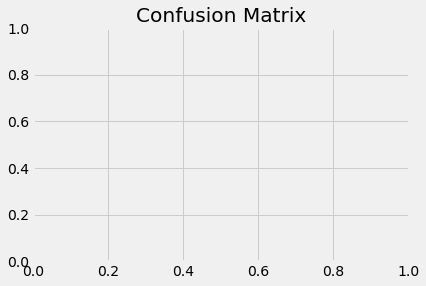

In [20]:
plotter = ConfusionMatrixPlotter(X_val=val_generator, classes=labels, Y_val=validation.category.values.astype(int))
epoch_loss = AccLossPlotter()

In [21]:
def train(model, train_data, val_data, toy):
        """
        Train the model
        """
        if toy:
            epochs=3

        else:
            epochs=100
            
        # We'll stop training if no improvement after some epochs
        earlystopper = EarlyStopping(monitor='val_loss', mode='min', patience=5 , restore_best_weights=True)

        # Save the best model during the traning
        checkpointer = ModelCheckpoint('best_model1.h5'
                                        ,monitor='val_loss'
                                        ,mode='min'
                                        ,verbose=1
                                        ,save_best_only=True)
        # Train
        training = model.fit(train_data, 
                            validation_data = val_data, 
                            epochs = epochs, 
                            verbose = 1,
                            batch_size = batch_size,
                            callbacks=[earlystopper, checkpointer,plotter, epoch_loss])
        
        print("Trained")
                            
        return training

2022-06-24 16:25:42.152850: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100


2022-06-24 16:25:44.623191: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


532/532 [==============================] - 108s 183ms/step - loss: 0.3338 - accuracy: 0.8743 - f1_m: 0.8705 - precision_m: 0.8843 - recall_m: 0.8578 - val_loss: 0.1991 - val_accuracy: 0.9365 - val_f1_m: 0.9364 - val_precision_m: 0.9405 - val_recall_m: 0.9324

Epoch 00001: val_loss improved from inf to 0.19910, saving model to best_model1.h5


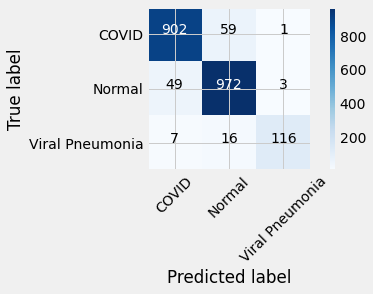

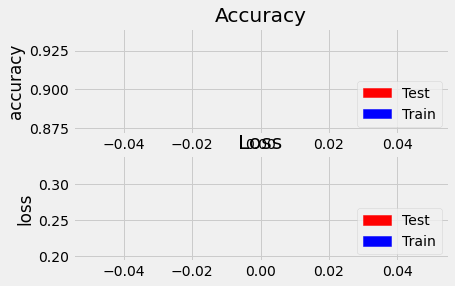

Epoch 2/100
532/532 [==============================] - 57s 107ms/step - loss: 0.1942 - accuracy: 0.9358 - f1_m: 0.9355 - precision_m: 0.9393 - recall_m: 0.9319 - val_loss: 0.1449 - val_accuracy: 0.9539 - val_f1_m: 0.9541 - val_precision_m: 0.9569 - val_recall_m: 0.9515

Epoch 00002: val_loss improved from 0.19910 to 0.14485, saving model to best_model1.h5


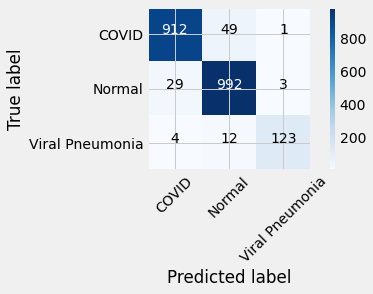

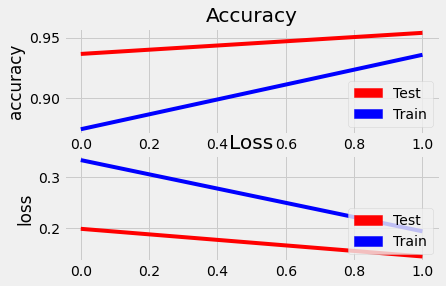

Epoch 3/100
532/532 [==============================] - 57s 107ms/step - loss: 0.1591 - accuracy: 0.9512 - f1_m: 0.9509 - precision_m: 0.9531 - recall_m: 0.9487 - val_loss: 0.1209 - val_accuracy: 0.9638 - val_f1_m: 0.9628 - val_precision_m: 0.9644 - val_recall_m: 0.9613

Epoch 00003: val_loss improved from 0.14485 to 0.12088, saving model to best_model1.h5


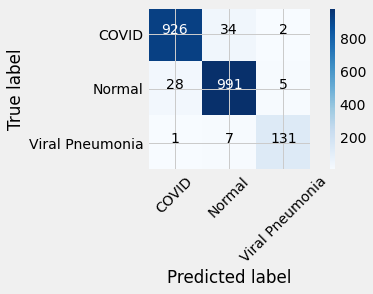

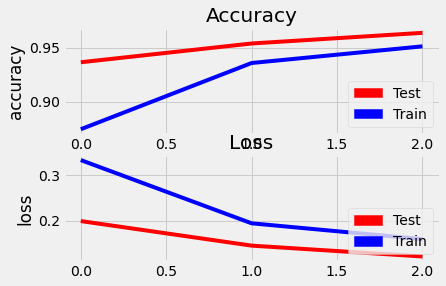

Epoch 4/100
532/532 [==============================] - 58s 110ms/step - loss: 0.1382 - accuracy: 0.9583 - f1_m: 0.9583 - precision_m: 0.9598 - recall_m: 0.9569 - val_loss: 0.1097 - val_accuracy: 0.9638 - val_f1_m: 0.9645 - val_precision_m: 0.9654 - val_recall_m: 0.9636

Epoch 00004: val_loss improved from 0.12088 to 0.10974, saving model to best_model1.h5


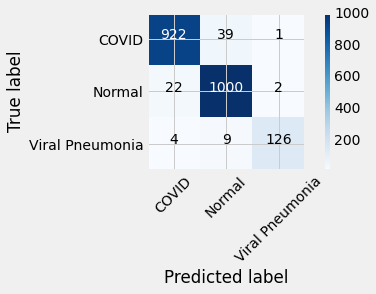

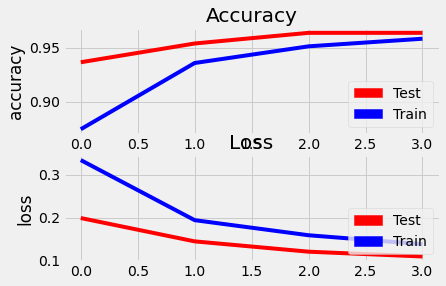

Epoch 5/100
532/532 [==============================] - 58s 109ms/step - loss: 0.1230 - accuracy: 0.9638 - f1_m: 0.9639 - precision_m: 0.9652 - recall_m: 0.9627 - val_loss: 0.1079 - val_accuracy: 0.9675 - val_f1_m: 0.9680 - val_precision_m: 0.9687 - val_recall_m: 0.9674

Epoch 00005: val_loss improved from 0.10974 to 0.10785, saving model to best_model1.h5


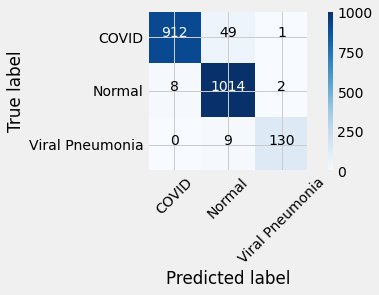

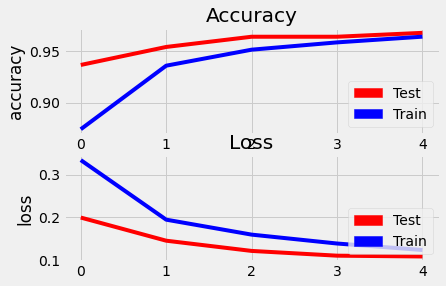

Epoch 6/100
532/532 [==============================] - 58s 109ms/step - loss: 0.1146 - accuracy: 0.9657 - f1_m: 0.9658 - precision_m: 0.9665 - recall_m: 0.9650 - val_loss: 0.0951 - val_accuracy: 0.9722 - val_f1_m: 0.9727 - val_precision_m: 0.9738 - val_recall_m: 0.9715

Epoch 00006: val_loss improved from 0.10785 to 0.09512, saving model to best_model1.h5


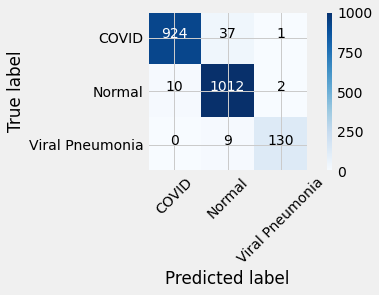

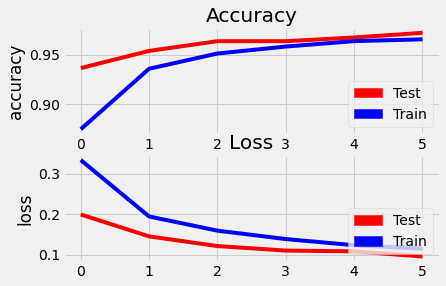

Epoch 7/100
532/532 [==============================] - 58s 109ms/step - loss: 0.1053 - accuracy: 0.9707 - f1_m: 0.9708 - precision_m: 0.9716 - recall_m: 0.9701 - val_loss: 0.1019 - val_accuracy: 0.9732 - val_f1_m: 0.9729 - val_precision_m: 0.9734 - val_recall_m: 0.9725

Epoch 00007: val_loss did not improve from 0.09512


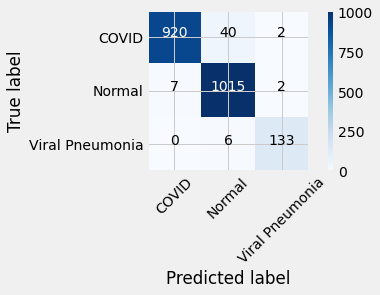

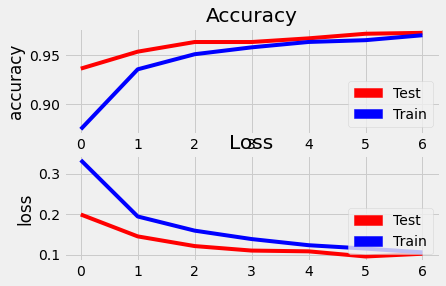

Epoch 8/100
532/532 [==============================] - 58s 110ms/step - loss: 0.1003 - accuracy: 0.9701 - f1_m: 0.9702 - precision_m: 0.9708 - recall_m: 0.9697 - val_loss: 0.1053 - val_accuracy: 0.9680 - val_f1_m: 0.9683 - val_precision_m: 0.9687 - val_recall_m: 0.9678

Epoch 00008: val_loss did not improve from 0.09512


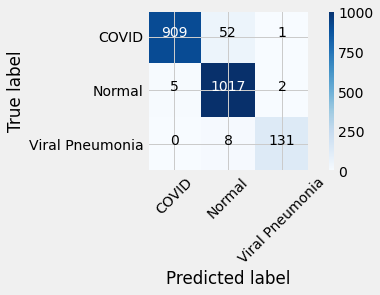

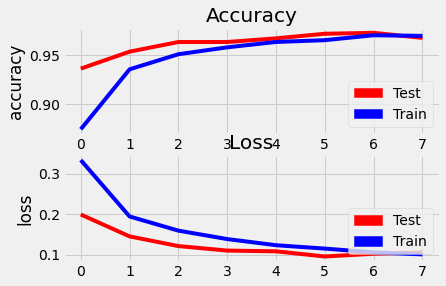

Epoch 9/100
532/532 [==============================] - 59s 111ms/step - loss: 0.0947 - accuracy: 0.9726 - f1_m: 0.9726 - precision_m: 0.9732 - recall_m: 0.9720 - val_loss: 0.0830 - val_accuracy: 0.9741 - val_f1_m: 0.9748 - val_precision_m: 0.9752 - val_recall_m: 0.9743

Epoch 00009: val_loss improved from 0.09512 to 0.08305, saving model to best_model1.h5


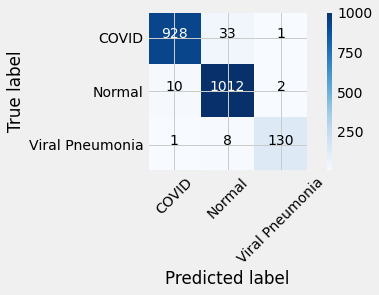

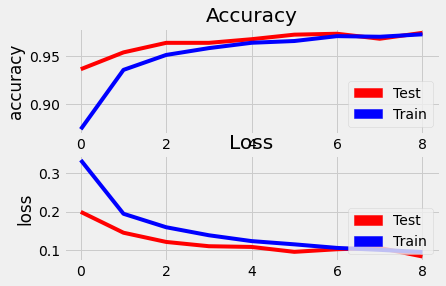

Epoch 10/100
532/532 [==============================] - 60s 112ms/step - loss: 0.0889 - accuracy: 0.9750 - f1_m: 0.9751 - precision_m: 0.9754 - recall_m: 0.9749 - val_loss: 0.0815 - val_accuracy: 0.9746 - val_f1_m: 0.9747 - val_precision_m: 0.9761 - val_recall_m: 0.9734

Epoch 00010: val_loss improved from 0.08305 to 0.08152, saving model to best_model1.h5


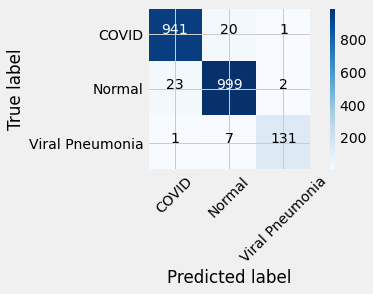

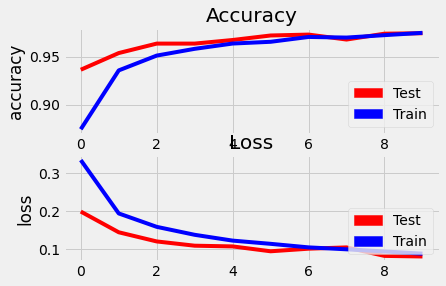

Epoch 11/100
532/532 [==============================] - 62s 116ms/step - loss: 0.0835 - accuracy: 0.9767 - f1_m: 0.9766 - precision_m: 0.9771 - recall_m: 0.9760 - val_loss: 0.0810 - val_accuracy: 0.9741 - val_f1_m: 0.9743 - val_precision_m: 0.9748 - val_recall_m: 0.9739

Epoch 00011: val_loss improved from 0.08152 to 0.08100, saving model to best_model1.h5


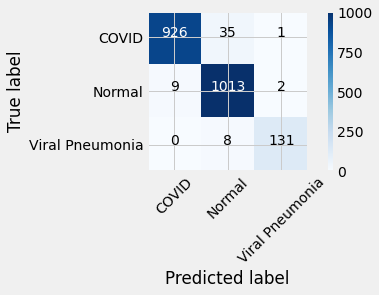

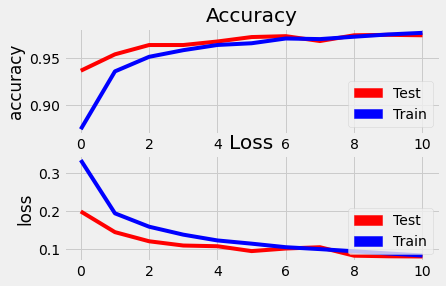

Epoch 12/100
532/532 [==============================] - 58s 109ms/step - loss: 0.0779 - accuracy: 0.9785 - f1_m: 0.9785 - precision_m: 0.9788 - recall_m: 0.9783 - val_loss: 0.0824 - val_accuracy: 0.9755 - val_f1_m: 0.9760 - val_precision_m: 0.9762 - val_recall_m: 0.9757

Epoch 00012: val_loss did not improve from 0.08100


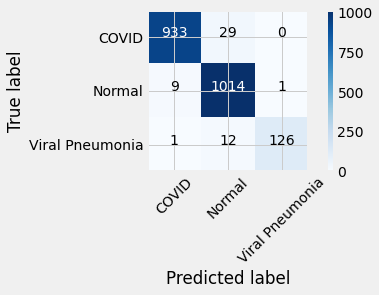

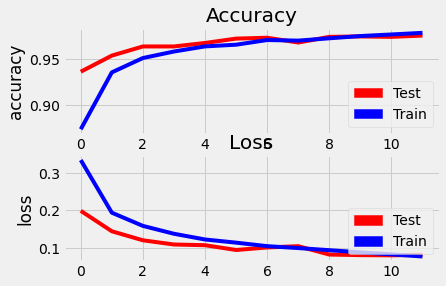

Epoch 13/100
532/532 [==============================] - 62s 116ms/step - loss: 0.0735 - accuracy: 0.9793 - f1_m: 0.9792 - precision_m: 0.9794 - recall_m: 0.9790 - val_loss: 0.0737 - val_accuracy: 0.9779 - val_f1_m: 0.9781 - val_precision_m: 0.9785 - val_recall_m: 0.9776

Epoch 00013: val_loss improved from 0.08100 to 0.07366, saving model to best_model1.h5


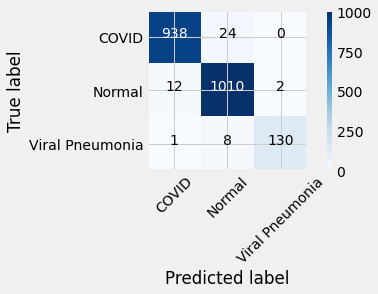

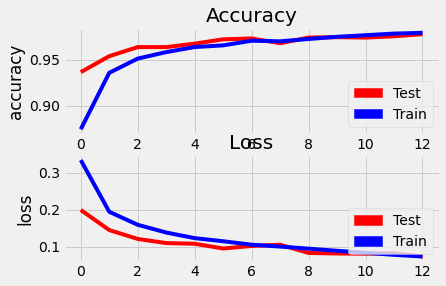

Epoch 14/100
532/532 [==============================] - 58s 109ms/step - loss: 0.0726 - accuracy: 0.9791 - f1_m: 0.9788 - precision_m: 0.9789 - recall_m: 0.9786 - val_loss: 0.0723 - val_accuracy: 0.9788 - val_f1_m: 0.9788 - val_precision_m: 0.9790 - val_recall_m: 0.9785

Epoch 00014: val_loss improved from 0.07366 to 0.07232, saving model to best_model1.h5


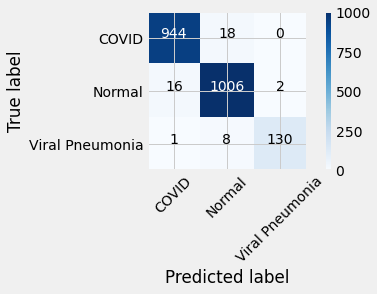

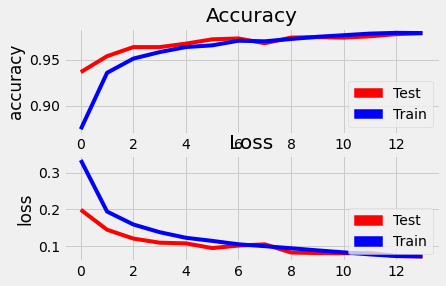

Epoch 15/100
532/532 [==============================] - 58s 109ms/step - loss: 0.0679 - accuracy: 0.9804 - f1_m: 0.9804 - precision_m: 0.9807 - recall_m: 0.9801 - val_loss: 0.0852 - val_accuracy: 0.9736 - val_f1_m: 0.9741 - val_precision_m: 0.9743 - val_recall_m: 0.9739

Epoch 00015: val_loss did not improve from 0.07232


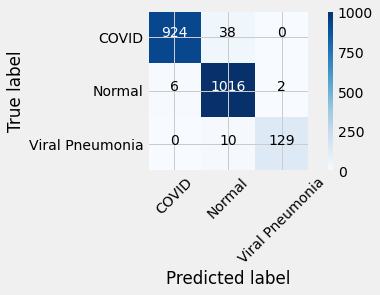

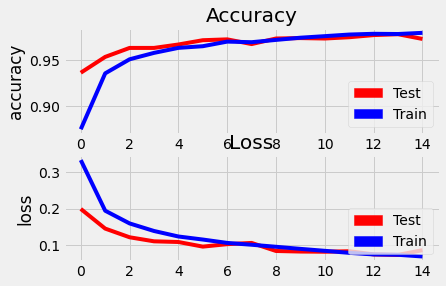

Epoch 16/100
532/532 [==============================] - 60s 113ms/step - loss: 0.0645 - accuracy: 0.9829 - f1_m: 0.9829 - precision_m: 0.9832 - recall_m: 0.9826 - val_loss: 0.0696 - val_accuracy: 0.9807 - val_f1_m: 0.9806 - val_precision_m: 0.9809 - val_recall_m: 0.9804

Epoch 00016: val_loss improved from 0.07232 to 0.06964, saving model to best_model1.h5


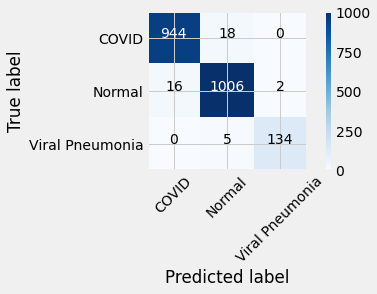

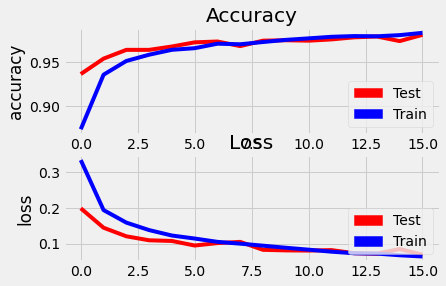

Epoch 17/100
532/532 [==============================] - 59s 110ms/step - loss: 0.0632 - accuracy: 0.9837 - f1_m: 0.9836 - precision_m: 0.9840 - recall_m: 0.9833 - val_loss: 0.0821 - val_accuracy: 0.9751 - val_f1_m: 0.9753 - val_precision_m: 0.9757 - val_recall_m: 0.9748

Epoch 00017: val_loss did not improve from 0.06964


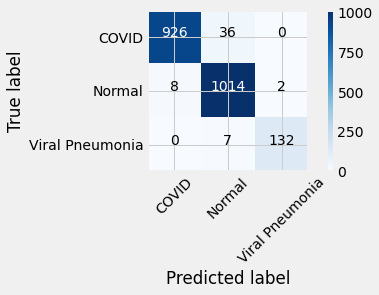

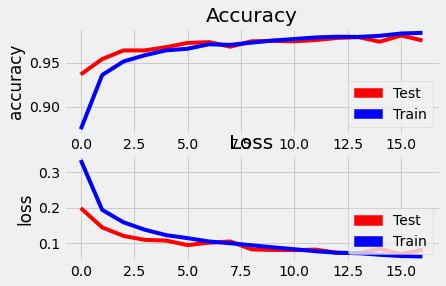

Epoch 18/100
532/532 [==============================] - 58s 108ms/step - loss: 0.0603 - accuracy: 0.9840 - f1_m: 0.9838 - precision_m: 0.9841 - recall_m: 0.9836 - val_loss: 0.0770 - val_accuracy: 0.9765 - val_f1_m: 0.9769 - val_precision_m: 0.9771 - val_recall_m: 0.9767

Epoch 00018: val_loss did not improve from 0.06964


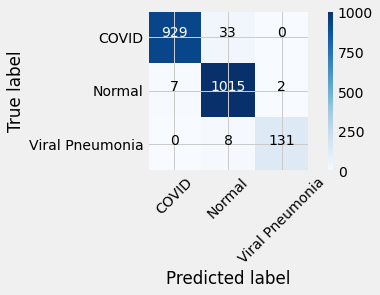

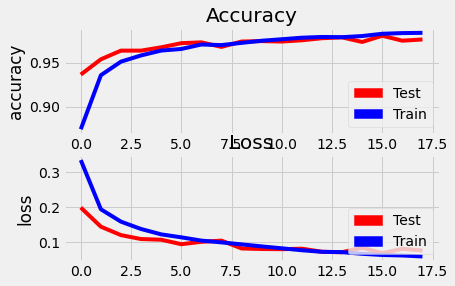

Epoch 19/100
532/532 [==============================] - 58s 109ms/step - loss: 0.0551 - accuracy: 0.9863 - f1_m: 0.9863 - precision_m: 0.9865 - recall_m: 0.9862 - val_loss: 0.0689 - val_accuracy: 0.9821 - val_f1_m: 0.9820 - val_precision_m: 0.9823 - val_recall_m: 0.9818

Epoch 00019: val_loss improved from 0.06964 to 0.06893, saving model to best_model1.h5


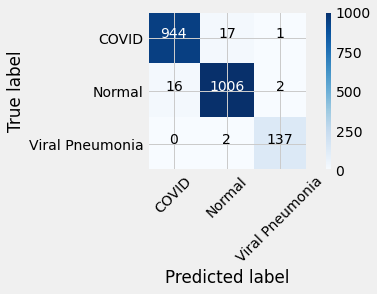

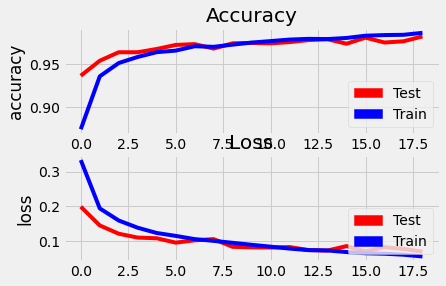

Epoch 20/100
532/532 [==============================] - 81s 153ms/step - loss: 0.0567 - accuracy: 0.9854 - f1_m: 0.9853 - precision_m: 0.9854 - recall_m: 0.9852 - val_loss: 0.0680 - val_accuracy: 0.9821 - val_f1_m: 0.9823 - val_precision_m: 0.9823 - val_recall_m: 0.9823

Epoch 00020: val_loss improved from 0.06893 to 0.06796, saving model to best_model1.h5


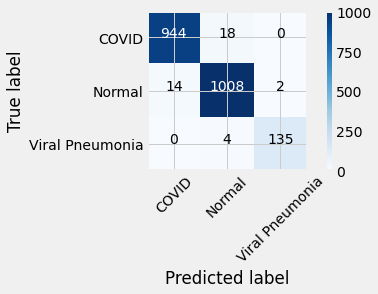

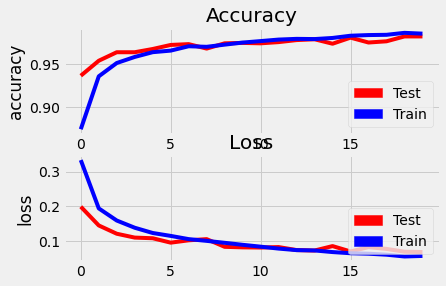

Epoch 21/100
532/532 [==============================] - 80s 150ms/step - loss: 0.0526 - accuracy: 0.9855 - f1_m: 0.9854 - precision_m: 0.9857 - recall_m: 0.9852 - val_loss: 0.0694 - val_accuracy: 0.9816 - val_f1_m: 0.9816 - val_precision_m: 0.9818 - val_recall_m: 0.9813

Epoch 00021: val_loss did not improve from 0.06796


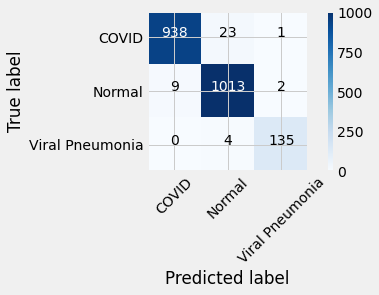

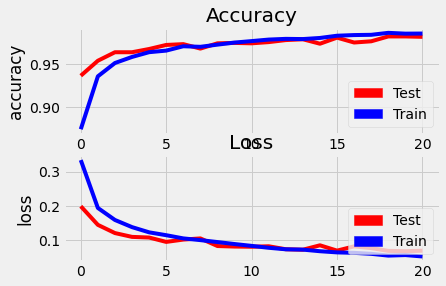

Epoch 22/100
532/532 [==============================] - 79s 149ms/step - loss: 0.0498 - accuracy: 0.9876 - f1_m: 0.9877 - precision_m: 0.9878 - recall_m: 0.9877 - val_loss: 0.0656 - val_accuracy: 0.9826 - val_f1_m: 0.9827 - val_precision_m: 0.9827 - val_recall_m: 0.9827

Epoch 00022: val_loss improved from 0.06796 to 0.06565, saving model to best_model1.h5


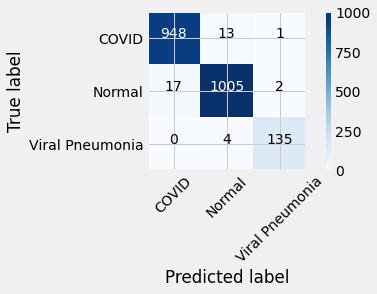

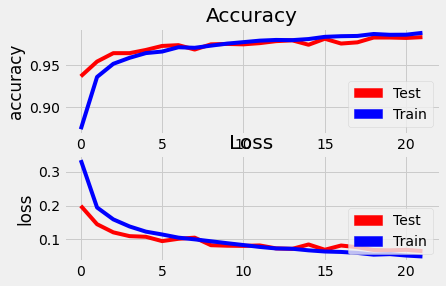

Epoch 23/100
532/532 [==============================] - 65s 123ms/step - loss: 0.0488 - accuracy: 0.9868 - f1_m: 0.9868 - precision_m: 0.9870 - recall_m: 0.9867 - val_loss: 0.0697 - val_accuracy: 0.9793 - val_f1_m: 0.9795 - val_precision_m: 0.9795 - val_recall_m: 0.9795

Epoch 00023: val_loss did not improve from 0.06565


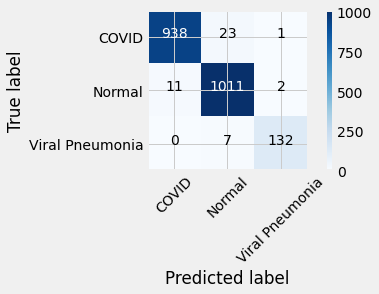

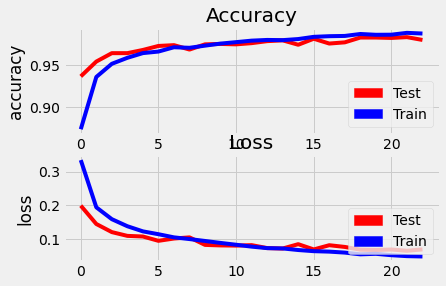

Epoch 24/100
532/532 [==============================] - 65s 123ms/step - loss: 0.0463 - accuracy: 0.9883 - f1_m: 0.9884 - precision_m: 0.9885 - recall_m: 0.9883 - val_loss: 0.0668 - val_accuracy: 0.9816 - val_f1_m: 0.9818 - val_precision_m: 0.9818 - val_recall_m: 0.9818

Epoch 00024: val_loss did not improve from 0.06565


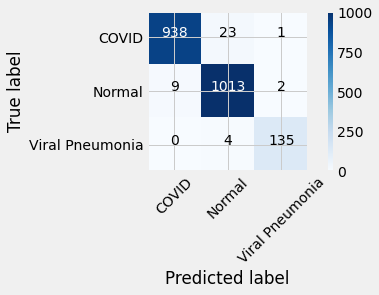

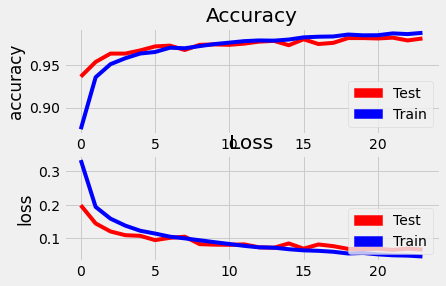

Epoch 25/100
532/532 [==============================] - 68s 129ms/step - loss: 0.0453 - accuracy: 0.9892 - f1_m: 0.9892 - precision_m: 0.9893 - recall_m: 0.9891 - val_loss: 0.0696 - val_accuracy: 0.9812 - val_f1_m: 0.9811 - val_precision_m: 0.9813 - val_recall_m: 0.9809

Epoch 00025: val_loss did not improve from 0.06565


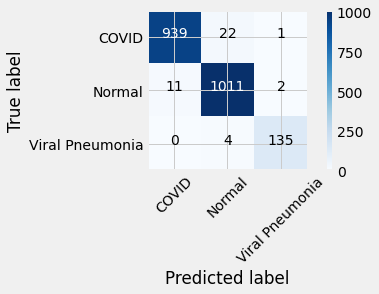

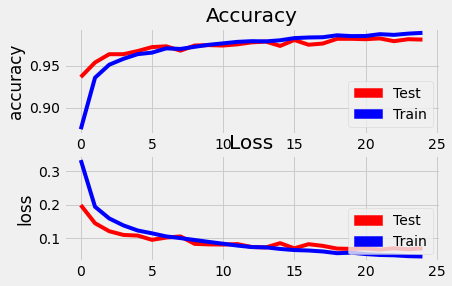

Epoch 26/100
532/532 [==============================] - 71s 132ms/step - loss: 0.0448 - accuracy: 0.9886 - f1_m: 0.9885 - precision_m: 0.9887 - recall_m: 0.9883 - val_loss: 0.0672 - val_accuracy: 0.9821 - val_f1_m: 0.9823 - val_precision_m: 0.9823 - val_recall_m: 0.9823

Epoch 00026: val_loss did not improve from 0.06565


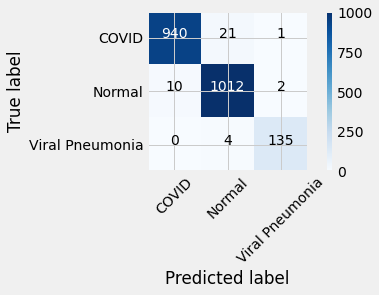

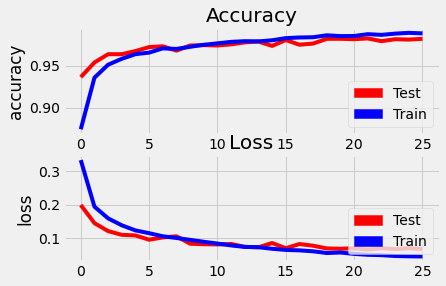

Epoch 27/100
532/532 [==============================] - 70s 131ms/step - loss: 0.0403 - accuracy: 0.9909 - f1_m: 0.9909 - precision_m: 0.9910 - recall_m: 0.9908 - val_loss: 0.0791 - val_accuracy: 0.9779 - val_f1_m: 0.9781 - val_precision_m: 0.9781 - val_recall_m: 0.9781

Epoch 00027: val_loss did not improve from 0.06565


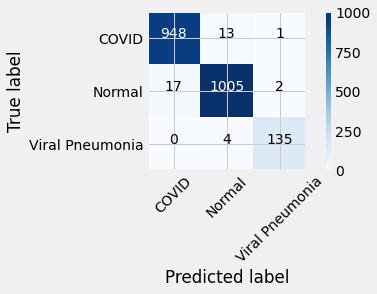

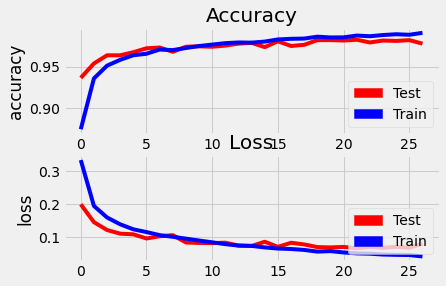

Trained


In [22]:
trained = train(model, train_generator, val_generator, toy)

# MODEL EVALUATION

## Generate Predictions

In [23]:
y_pred_raw = model.predict(test_generator)
y_pred = np.argmax(y_pred_raw, axis=1)
y_true = test.category.values
y_true=y_true[:len(y_pred)]

## Metrics Plot Functions

In [24]:
def plot_history(training):
        """
        Plot training history
        """
        ## Trained model analysis and evaluation
        f, ax = plt.subplots(1,2, figsize=(15,8))
        ax[0].plot(training.history['loss'], label="Loss")
        ax[0].plot(training.history['val_loss'], label="Validation loss")
        ax[0].set_title('Loss')
        ax[0].set_xlabel('Epoch')
        ax[0].set_ylabel('Loss')
        ax[0].legend()

        # Accuracy
        ax[1].plot(training.history['accuracy'], label="Accuracy")
        ax[1].plot(training.history['val_accuracy'], label="Validation accuracy")
        ax[1].set_title('Accuracy')
        ax[1].set_xlabel('Epoch')
        ax[1].set_ylabel('Accuracy')
        ax[1].legend()
        plt.tight_layout()
        plt.show()

def train_report(training):
    print("------- Training Report -----------")
    print("Accuracy: %0.2f" % (np.mean(training.history['accuracy'])*100))
    print("F1 Score: %0.2f" % (np.mean(training.history['f1_m'])*100))
    print("Precision: %0.2f" % (np.mean(training.history['precision_m'])*100))
    print("Recall: %0.2f" % (np.mean(training.history['recall_m'])*100))
    print("Loss: %0.2f" % (np.mean(training.history['loss'])))

    print("------- Validation Report -----------")
    print("Accuracy: %0.2f" % (np.mean(training.history['val_accuracy'])*100))
    print("F1 Score: %0.2f" % (np.mean(training.history['val_f1_m'])*100))
    print("Precision: %0.2f" % (np.mean(training.history['val_precision_m'])*100))
    print("Recall: %0.2f" % (np.mean(training.history['val_recall_m'])*100))
    print("Loss: %0.2f" % (np.mean(training.history['val_loss'])))

def print_report():
    """
    Predict and evaluate using ground truth from labels
    Test generator did not shuffle 
    and we can use true labels for comparison
    """
    #Print classification report
    print(metrics.classification_report(y_true, y_pred.astype(str), target_names = labels))
    
def print_conf_mtx():
    
    cm = confusion_matrix(y_true.astype(int), y_pred)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

    disp.plot(cmap=plt.cm.Blues)
    plt.show()

## Results

------- Training Report -----------
Accuracy: 97.30
F1 Score: 97.28
Precision: 97.39
Recall: 97.18
Loss: 0.09
------- Validation Report -----------
Accuracy: 97.37
F1 Score: 97.39
Precision: 97.45
Recall: 97.33
Loss: 0.09


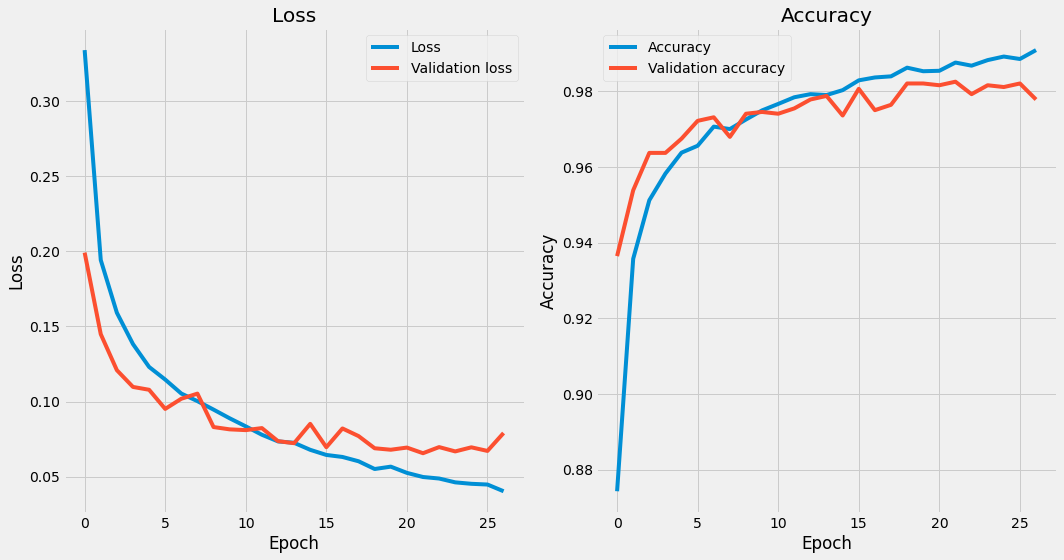

                 precision    recall  f1-score   support

          COVID       0.97      0.98      0.97       967
         Normal       0.98      0.97      0.97      1023
Viral Pneumonia       0.96      0.93      0.95       136

       accuracy                           0.97      2126
      macro avg       0.97      0.96      0.96      2126
   weighted avg       0.97      0.97      0.97      2126



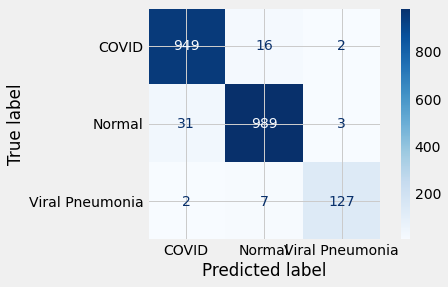

In [25]:
train_report(trained)
plot_history(trained)
print_report()
print_conf_mtx()